# Replication Notebook for "Fiscal and Monetary Policy with Heterogeneous Agents" by Auclert et al. (2025) 
#### Course: HANK in Macroeconomics | Supervisor: Selma Malmberg (CEPREMAP)
#### Authors: Maximilian Stein & Gabriele Piantoni | Submitted on December 9th, 2025

This notebook will combine the calibrated household block from `household.ipynb` and its parametric outcomes from `hh_parameter.json`, which then replicates Figure 2(a) and (b) from Auclert et al. (2025). Hence, it combines the three distinct household blocks for the HA, TA and RA models.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
import sequence_jacobian as sj # sequence-space Jacobian toolkit

from household import hh_ha, hh_ta, hh_ra

In [3]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (4, 3)})
#plt.rcParams.update({'text.usetex': True, 'font.serif': 'Palatino'})

## Model Building

Auclert et al . (2025) decided for a standard incomplete markets model with underlying Bewley Huggett-Aiyagari characteristics - meaning incomplete insurance markets and heterogeneous households, describing ex-ante similiar households, which change ex-post, because they are exposed to different idyiosyncratic shocks, which they can only insure againts through riskless bonds or capital as financial markets are incomplete Kirkby (2019). Merged with the New Keynesian Paradigm of forward‑looking households and firms with market imperfections like sticky prices and wages, the model is underlying for calibration of marginal propensities for consumption, aggregate values of income and wealth as well respectively their distributions.

### The Household

The economies household decision making is ruled by the following consumption maximisation problem: 

\begin{align*}
     max_{\{c_{it}\}} \quad &E_0 \left[\sum_{t=0}^\infty\left(\prod_{s \leq t-1}\beta_{is}\right)\{\underbrace{log(c_{it})}_{consumption~utility} - \underbrace{v(n_{it})}_{disutility~of~labour}\}\right] \\[8mm] \tag{1}
     \text{s.t.} \quad& \underbrace{c_{it}}_{consumption~in~t} + \underbrace{a_{it}}_{assets~in~t} \leq \underbrace{(1 + r^{p}_{t})a_{it-1}}_{asset~value~after~return} + \underbrace{(1-\tau_i)w_te_{it}n_{it}}_{After‑tax~labor~income} \\[8mm]
     & \underbrace{a_{it} \geq 0}_{no‑borrowing~constraint} 
\end{align*}

This comprises as a model with unit mass of agents $i \in[0,1]$ that are identical ex-ante but become heterogeneous ex-post because each individual is hit by private shocks $e_{it}$ to labor productivity and to their discount factor $\beta_{it}$, which follow an exogenous Markov process expressing the transitions from one state of shocks and discount factor ($e,\beta$) to another ($e',\beta'$) (expressed by the matrix $\prod(e', \beta' | e,\beta)$); the cross‑sectional distribution over these states is kept at its stationary value, and average efficiency units of labor are normalized to one.

To study dynamics, the authors consider small, one‑time, unexpected disturbances at date 0 (MIT shocks to aggregates like $r_t, w_t$ and $\tau_t$) that move the economy away from its stationary equilibrium. This corresponds to computing first‑order IRF's in a fully stochastic counterpart. Each household $i$ has time‑separable preferences with $log(u({c_{it})})$ utility in consumption and a separable disutility of labor $v(n_{it})$, supplies efficient units of labor ($e_{it}n_{it}$) according to an exogenously set hours choice nit (e.g., by working unions), pays labor income taxes at rate $\tau_t$, and saves in a mutual fund with assets ait subject to a zero‑borrowing constraint $a_{it} \geq 0$, earning the realized return on the fund $r^p_t$.

This poses an individual problem as with given idiosyncratic income risk ($e_{it}$ shocks) and the inability to borrow or fully insure, agents choose consumption $c_{it}$ and next‑period assets $a_{it+1}$ to smooth consumption over time while self‑insuring against income fluctuations. The combination of income risk ($e_{it}$), discount factor heterogeneity ($\beta_{it}$), and borrowing constraints ($a_{it} \geq 0$) generates realistic risk-averse saving behavior.

### The Supply Side

The first step of the model is to define the `production` function, which takes as input $Y$ (_aggregate production_) and $\mu$ (_markup_), and return $N$ (_effective labor_), $Nw$ (_aggregate real wage_) and $\text{div}$(_pre-tax dividend_).

The authors assume that firm output equals the aggregate of effective labour, acting as price setters including a mark-up attached to the nominal wage over their nominal marginal resulting in a price as of $P = \mu W_t$, implying that real wage $w = \frac{1}{\mu}$.

$$
    Y_t = N_t, \qquad N_t = \mathrm{E}[e_{it}n_{it}]
$$

Introducing a _dividend tax_ equal to _labour income tax_ $\tau_i$, the post-ex dividends are

$$
d_t = \underbrace{(1-\tau)}_{corporate~tax}\underbrace{(Y_t - w_t N_t)}_{Pre‑tax~profits} = \underbrace{(1-\tau)\left(1-\frac{1}{\mu}\right)Y_t}_{After‑tax~profit~share~of~output}.
$$

With the New Keynesian paradigm comes price stickyness and the authors use the following assumptions from the literature towards price stickyness: As of subject to maximise agents utility under constraint of adjustment cost, wages are set by workers union Erceg (2000). Unions know how to allocate all labour hours over workforce and do so uniformly Auclert (2019). The union sets wages to maximize the expected utility of a worker with average consumption Hagedorn (2019), Auclert (2019). 

In [4]:
@sj.simple
def production(Y, mu):
    N = Y
    wN = Y / mu
    div = Y - wN
    return N, wN, div

#### The New Keynesian Phillips Curve (NKPC)


The beforehand mentioned assumptions yield a linear wage first-order *Phillips curve* for wage inflation under Calvo-Pricing in the form of

$$
\underbrace{\pi_t^w}_{wage~inflation~today} = \underbrace{\kappa}_{Calvo~Stickiness~>~0}
  \left(\underbrace{v'(N_t)}_{Aggregate~labour~disutility}-\underbrace{\frac{1-\tau_t}{\mu C_t}}_{marginal~gain~from~labour~input}\right)
 + \underbrace{\bar{\beta}\pi_{t+1}^w}_{future~inflation~expectation~with~discounted~expectation}
\tag{2}
$$

Before interpreting the code, recall that prices are a constant markup over wages, $P_t = \mu W_t$.
As a result, all inflation dynamics originate from **wage inflation**, and the NKPC in this model is derived directly from the wage-setting problem of unions. 

Wage inflation arises whenever the marginal disutility of working an extra hour, $v'(N_t)$), is higher than the marginal gain to a worker with average consumption. That gain is given by the after‑tax real wage $\frac{1-\tau_t}{\mu}$ times the marginal utility of average consumption, $\frac{1}{C_t}$, evaluated over current and future periods. Finally, note that unions optimize on behalf of the **average worker**, so marginal utility terms are evaluated at average consumption.

Hence, the Philipps Curve describes the behaviour of price inflation, keeping in mind that prices where set as with a constant markup above the nominal wage, which equalises the terms of price and wage inflation $\pi_t^w = \pi_t = \frac{P_t-P_{t-1}}{P_{t-1}}$. Finally, dividends before taxes are defined as the residual of output after paying total labor income:
$\text{div}_t = Y_t - w_t N_t$.


In [5]:
@sj.simple
def nkpc(pi, kappa, N, Y, G, beta_ave, vscale, frisch, tax_rate, mu, eis):
    wedge = vscale*N**(1/frisch) - (1-tax_rate) / mu * (Y-G)**(-1/eis)
    nkpc_res = kappa * wedge + beta_ave * pi(+1) - pi
    return nkpc_res

While the paper often treats the real interest rate path as exogenous, it also considers an alternative specification in which monetary policy follows a Taylor rule.
In this case, the nominal rate adjusts in response to inflation, and the implied real rate is determined endogenously through the Fisher relation.

In [6]:
@sj.simple
def taylor_rule(rstar, pi, phi):
    """Taylor rule for monetary policy"""
    i = rstar + phi * pi
    r_ante = i - pi(+1)
    return r_ante

### Government Structure & Endowments


The model's governments budget consists of it's spending $G_t$ and debt in the current state $B_t$ which equals it's collection of labor and corporate taxes as a sum of tax revenue $Y_t$ added by the returns from government bonds it possesses from a period before the constraint is

$$
\underbrace{G_t + B_t}_{Gov.~budget} = \underbrace{(1 + r_{t-1}) B_{t-1}}_{past~debt~refinancing} + \underbrace{\tau_t\mathcal{Y}_t}_{tax~revenue}. \tag{3}
$$

According to a given intertemporal budget constraint, the defined government set-up is supposed to have a strategy in setting $G_t$ and $\tau_t$ accordingly as well as for bonds $B_t$ and spending $G_t$, however, with a still budget constraint respected tax rate.


The `fiscal` function takes $B$, $r_{\text{post}}$, $G$, $Y$, $wN$, and $\text{div}$ as inputs and returns
the implied tax rate, after-tax wage income, and after-tax dividends.

The function is built around the computation of total tax revenue \(T\), obtained by
rearranging the government budget constraint. Once \(T\) is determined, the tax rate
follows as the ratio \(T / Y\). Given this tax rate, the function computes the after-tax
values of aggregate real wage income and aggregate dividends.

In [ ]:
@sj.simple
def fiscal(B, r_post_bonds, G, Y, wN, div, tax_rate_shock):
    """Calculate taxes and after-tax wage and dividend income"""
    T = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden consistent with B and G
    tax_rate = T / Y                        # required tax rate
    wN_aftertax = (1 - tax_rate) * wN       # after-tax wage income
    div_aftertax = (1 - tax_rate) * div     # after-tax dividends

    # ALW (2024) rule
    tax_rate_res = tax_rate - tax_rate.ss - tax_rate_shock

    return T, tax_rate, wN_aftertax, div_aftertax, tax_rate_res


### Asset Market Structure
#### Conditions

Further assumptions are made on asset markets. They assume a simple asset market and policy environment. It includes mutual fund collection of household savings $a_it$ and thus two-folded investment either in government bonds or the stock market. 

The first function (`capitalization`) specifies two fundamental elements.

_Note: the decorator `@sj.solved` instructs the solver to determine the value of \(p\) (searched over the interval \([0.001, 50]\)) that sets the condition `cap_cond` equal to zero._

1. **The no-arbitrage condition**, which imposes that the equity price satisfies
   $$
   p_t = \frac{d_{t+1} + p_{t+1}}{1 + r_t},
   $$
   thereby ensuring consistency with the model’s asset-pricing equation.

2. **The ex-post return on equity**, given by
   $$
   r^{\text{post}}_{t,\text{equity}}
   = \frac{d_t + p_t}{p_{t-1}} - 1,
   $$
   representing the realized return between periods \(t-1\) and \(t\).

The second function (`ex_post_r`) defines the **ex-post return on the overall asset portfolio**, obtained as a weighted average of equity and bond returns, where the weights correspond to the respective asset holdings in the previous period.

In [8]:
@sj.solved(unknowns={'p': (0.001,50)}, targets=['cap_cond'])
def capitalization(div_aftertax, r_ante, p):
    cap_cond = p - (div_aftertax(+1) + p(+1))/(1 + r_ante)
    r_post_equity = (div_aftertax + p)/p(-1) - 1
    return r_post_equity, cap_cond

@sj.simple
def ex_post_r(r_post_equity, r_post_bonds, B, p):
    r = (p(-1) * r_post_equity + B(-1) * r_post_bonds) / (p(-1) + B(-1))
    return r

##### Market Closing Conditions

This block simply defines the market-clearing conditions for the asset market and the goods market, corresponding to equations (5) and (7) of the model.

Total households assets must exactly equal the value of equity plus public debt

$$
    A_t = p_t + B_t \tag{5}
$$

Because mutual funds are perfectly competitive, the fund just passes through the bond return to households, and its initial return is the portfolio‑weighted average of the stock and bond returns:

$$
    (1 + r^p_0)A = p_0 + d_0 + (1+r)B \tag{6}
$$

Monetary policy sets the real interest rate on government bonds via a standard interest‑rate rule with $1+i_t = (1+r_t)(1+\pi_{t+1})$ and a competitive equilibrium is then defined as prices, quantities, and household decisions such that households optimize and both asset and goods markets clear such that consumption and government spending equal the economies output

$$
    C_t + G_t = Y_t \tag{7}
$$

Once two of equations (5) to (7) hold, the third one will be satisfied automatically - by Walras’s law, if all markets but one clear, the last one must clear too.

In [9]:
@sj.simple
def mkt_clearing(A, Y, C, p, B, G):

    asset_mkt = A - p - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt

#### Short-term Government Bond Structure

This block defines the structure of short-term real government bonds though `rea_ST_bond` function. A one-period bond purchased at time $t$ pays $1$ unit of consumption at time $t+1$.

The real ex-post return (`r_post_bond`) on the bond satisfies: 
$$
r^{\text{post}}_{t} = r^{\text{ante}}_{t-1},
 $$
meaning that the realized return at time t is the rate that was promised in the previous period, excluding uncertainty. The price of the bond at time t (`q_bond`), denoted $q_t$, is the present value of its payoff:

$$
q_t = \frac{1}{1 + r^{\text{ante}}_t}.
$$

Given a known promised return, the bond’s price adjusts so that holding the bond
earns exactly the real rate $r^{\text{ante}}_t$ between t and t+1. This simple one-period structure is sufficient for our replication. The paper, however, considers richer environments, such as long-term nominal and real government debt.

In [10]:
@sj.simple
def real_ST_bonds(r_ante):
    r_post_bonds = r_ante(-1)
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

## Assemblance of Full Model


Here all previously defined functions are assembled into `common_blocks`, which represents the macroeconomic structure shared by all model variants. These blocks include production, fiscal policy, asset pricing, the NKPC, and the market-clearing conditions, and are identical across HA, TA, and RA specifications.

Each full model is then constructed by combining the common macro structure with its corresponding household block (see household py.). Although the code generates all three versions (HA, TA, and RA), our analysis focuses on the **HA model**, while the TA and RA variants serve as benchmarks for comparison.

In [11]:
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]

models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']

models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}

### Calibration

The following section defines the author's calibration for the steady state of the economy. In a further static analysis, we will change parameters to check for different outcomes under our assumptions.

Under quarterly frequency, the authors calibration approximates time by values at quarterly points so that it fits the model’s quarterly timing, modifying the original continuous-time income process $e_{it}$ based on Kaplan (2018). Their main goal is to find a good approximation of the wealth level and distribtion for most recent U.S. economy data. We comment on the authors calibration in the following paragraph.


The authors build their calibration using U.S. macro aggregates (wealth‑, debt‑, spending‑ and tax‑to‑GDP ratios, and a long‑run real interest rate) from national accounts and fiscal statistics. Their assets-to-GDP calibration $A$ is supported by U.S. Bureau of Economic Analysis (2025) data. However, their bonds-to-GDP $B$ value is lower than what U.S. Office of Management and Budget
and FRED St. Louis (2025) data from 2020 on would suggest, while their value for government spending to GDP value $G$ rather matches the U.S. level from 1950's, being constantly within a range of 30\% - 40\% according to IMF (2025) Public Financ data. With their beforehand mentioned calibrations, they compute a a tax-to-GDP ratio $T/Y$ of 22\% ($\frac{G}{Y} + r\frac{B}{Y}$) which would not quite match IMF (2025) having been on it's highest level (13\%) in 2000 lowest level in 2009 (7.9\%) within a 1973 - 2023 period. They then select preference heterogeneity parameters ($\beta^L = 0.91, \beta^H = 1$ and  $\omega$) to match the Board of Governors of the Federal Reserve System (2019) distribution after assuming that the discount factor $\beta$ follows a two-state Markov chain, so that agents switch between ‘patient’ and 'impatient' types. These parameters are disciplined by matching the Board of Governors of
the Federal Reserve System (2019) wealth distribution and a target for the income‑weighted MPC. The markup is inferred residually to produce a plausible equity‑to‑GDP ratio within the model. 

*The Phillips-curve* is treated secondary by the authors as they mainly care about real quantities, which they can compute without pinning down inflation in detail. They only specify Phillips-curve parameters to be able to solve for inflation paths when needed, not because these parameters drive their core calibration. Thus simple and conventional values for the nominal block (Frisch elasticity $\mathrm{v} = 1$, a small Phillips‑curve slope with normalization to $Y = 1$) are chosen, because we identify their research question to be about heterogeneity and real allocations, not about fine‑tuning inflation dynamics.

In [12]:
Y = 1           # normalization
r = 0.005       # 2% annual real interest rate
A = 20          # 500% assets to annual GDP
B = 4           # 100% debt to annual GDP
G = 0.2         # 20% gov spending
C = Y - G       # remaining 80% is consumption

tax = G + r*B                   # implied steady-state tax rate
j = A - B                       # firm equity to GDP
div_post = r * j                # implied post-tax dividends to justify firm equity
div = div_post / (1 - tax)      # implied pre-tax dividends
w_post = (1 - tax) * (1 - div)  # implied post-tax wage
mu = 1 / (1 - div)              # implied markup
mu

1.1142857142857143

In [13]:
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]

models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']

models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}

In [15]:
eis = 1                                      # elasticity of intertemporal substitution
frisch = 1                                   # Frisch elasticity of labor supply (only needed for Phillips curve)
vscale = w_post / C**(1/eis) / Y**(1/frisch) # implied parameter scaling wage disutility for zero steady-state pi

In [16]:
common_params = dict(Y=Y, r_ante=r, A=A, B=B, G=G, C=C, mu=mu, eis=eis, frisch=frisch, vscale=vscale,
            pi = 0,                # steady-state inflation
            kappa = 0.01,          # quarterly NKPC slope
            tax_rate_shock = 0,    # tax rate "shock" (only used with ALW rule),           # Tax level shock (only used with FTPL)
            zeta = 0,              # income risk cyclicality parameter (only used to make income risk countercyclical)
            )

Once the parameter has been calibrated, it is possible to start to find the steady state.

In [17]:
ss = {}

### Agent Steady State Calculation

#### Baseline HA Model
The HA model has been separately calibrated in `household.ipynb`.

In [41]:
with open('hh_params.json') as f:
    ha_params = json.load(f)

ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})
ss['ha']['asset_mkt'], ss['ha']['goods_mkt'], ss['ha']['nkpc_res']

(2.2325252757582348e-11, 5.881725488876555e-07, -2.220446049250313e-18)

#### Representative Agent Model
The model imposes that a representative agent solves the consumption maximisation problem in (1) with no risk on idiosyncratic income or the discount factor, while they are further able to borrow without constraints, making it a special case as mentioned by the authors. Thus, household consumption for this agent follows a textbook-like *Euler Equation* 

$$
\underbrace{C_t^{-1}}_{consumption~today} = \underbrace{\beta(1+r_t)C^{-1}_{t+1}}_{consumption~tomorrow}
$$ 

with $\beta = \frac{1}{1+r}$. The discount factor in this special case is set directly from the steady-state interest rate.

In [19]:
beta = 1 / (1 + r)
ra_params = dict(beta=beta, beta_ave=beta)
ss['ra'] = models['ra'].steady_state({**ra_params, **common_params}, dissolve=['hh_ra'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

#### Two Agent Model

The Bilbiie (2008, 2019) and Ascari (2016} based two-agent model defines a share $(1-\lambda)$ of agents whose behaviour is described by the prelemenary defined Euler equation, indexed for an unconstrained agent and a share $\lambda$ of agents who do not have access to capital markets, constraining them in that their net-income labor income will always equal their consumption. Overall it is assumed that both all agents have the same productivity $e_{it}$ and join the labour force $(n_{it} = N_{t})$. For constrained agents it means that consumption equals the after tax labor income and the economies aggregate consumption is the sum of unconstrained and constrained agents' consumption $C_t = (1-\lambda)C^u_t + \lambda C^c_t$.

This block constructs the steady state of the two-agent (TA) model, which approximates the heterogeneous-agent environment by combining optimizing households with a fraction `lam` of hand-to-mouth consumers. Following the logic in the paper, `lam` is chosen so that the implied aggregate MPC matches that of the HA model. Since hand-to-mouth agents consume their current labor income, the residual consumption of optimizing households (`C_RA`) is backed out to satisfy the TA resource identity.

The steady state is then computed using the TA household block, dissolved to remove its dynamic structure, yielding the static allocation consistent with the TA approximation. Checking the equilibrium residuals ensures that the TA model satisfies asset-market clearing, goods-market clearing, the government budget constraint, and the representative household’s Euler condition, just as in the theoretical construction of the TANK benchmark in the paper.

In [20]:
beta = 1 / (1 + r)
lam = 0.2 - r / (1+r)
C_RA = (C - lam * w_post) / (1 - lam)
ta_params = dict(beta=beta, beta_ave=beta, lam=lam, C_RA=C_RA)
ss['ta'] = models['ta'].steady_state({**ta_params, **common_params}, dissolve=['hh_ta'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

#### Caching Pre-Calculate Household Jacobians


Here the Jacobian for the heterogeneous-agent household block is computed over a horizon `T = 400`. This step constructs the linear response of aggregate household consumption (`C`) and assets (`A`) to shocks in wages, labor, and the interest rate—exactly the objects needed for the sequence-space solution method used in the paper.

The final line prints the block’s name (`'hh_ha'`) to verify that the Jacobian is properly assigned to the household block within the model structure. This ensures that subsequent impulse-response computations correctly reference the heterogeneous household component, consistent with the theoretical framework where household heterogeneity crucially shapes aggregate dynamics.

In [ ]:
T = 400
Js = {'hh_ha': hh_ha.jacobian(ss['ha'], inputs=['wN_aftertax','N','r'], outputs=['C','A'], T=T)}
hh_ha.name # verify that 'hh_ha' is the name of the het-agent household block

'hh_ha'

## Fiscal Policy

The authors consider two types of fiscal policy shocks, while imposing a taylor rule of constant inflation with an interest rate being at it's steady state, and therefore holding monetary policy constant. In the model, a fiscal policy shock either results from holding deficits constant while observing a shock on government spending $G_t$ or viceversa, keeping government spending constant, while observing a shock to it's deficits. 

Thus, as Figure 2(a) and (b) only focus on responses to deficit-financed tax cuts in in RA, TA, HA and respectively other alternative HA models, it is the latter aforementioned that we will focus on in our analysis. Once the interest rate is kept at it's steady state, Equation (8) can be rewritten toward resulting the Auclert (2024) defined "Intertemporal Keynesian cross" as

\begin{align}
\mathbf{d}C &= \bar{M}^r\,\mathbf{d}r + \bar{M}\,(\mathbf{d}Y - \mathbf{d}T),
\quad \text{with} \quad r_t = 0, \quad  \mathbf{d}C + \mathbf{d}G = \mathbf{d}Y \\[4pt]
\mathbf{d}Y &= \bar{M}(\mathbf{d}Y-\mathbf{d}T) + \mathbf{d}G \tag{10}
\end{align}

This expression links the sequence of post‑tax income changes and government spending to the sequence of output responses. For a balanced‑budget spending shock $(dG=dT, dB=0)$ the solution is $dY=dG$, so the fiscal multiplier equals one, exactly as in a representative‑agent model. We implement this condition numerically by solving, for each experiment, for the path of $Y_t$ that clears the asset market, given an exogenous path for government debt generated by the specified fiscal rule, and we then compare the resulting output impulse responses across the RA, TA, and HA specifications.

The deficit-financed shock follows a fiscal rule in equation (11) which assumes that the economy has a possibility to follow its path back towards a steady state. 

\begin{align*}
    \mathbf{d}B_t = \rho_B\mathbf{d}B_{t-1} - \mathbf{d}T_{t}^{shock} \tag{11}
\end{align*}

with $\mathbf{d}T_{t}^{shock}$ beeing the shock component and $\rho_B$ as the persistence term of debt which has been already accumulated in periods before the shock. It's calibration implies that debt will be paid of after ten years. 


This code constructs the deficit-financed tax cut shock as presented in the paper. First, `dT_shock = -rho**np.arange(T)` creates a one-unit tax cut at t=0 that decays geometrically with persistence rho. Then debt is initialized as `dB[0] = -dT_shock[0]`, because the government budget constraint implies that a tax cut must be financed by an equal rise in debt on impact. Finally, debt evolves according to `dB[t] = rho_B * dB[t-1] - dT_shock[t]`, meaning debt is highly persistent (rho_B ≈ 0.975) and increases each period by the size of that period’s tax cut. This produces the debt path required to finance the entire sequence of tax cuts.

In [24]:
rho_B, rho = 0.975, 0.9

dT_shock = -rho**np.arange(T)
dB = np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]

### Deficit-Financed Fiscal Result Replication
#### Figure 2(a)

This line computes the output responses for each model (HA, TA, RA) to the deficit-financed tax cut. For every model `k`, it solves the linearized equilibrium system using `solve_impulse_linear`, treating output `Y` as the unknown that must adjust so that the asset market clears (`asset_mkt = 0`). The input shock is the previously constructed debt path `dB`, passed as `inputs={'B': dB}`. The function returns impulse responses for all variables, but only the response of `Y` is kept (`['Y']`), producing `irfs_B[k]`, the output IRF for model `k`.


In [39]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], unknowns=['Y'], targets=['asset_mkt'],
                                            inputs={'B': dB}, outputs=['Y'], Js=Js)['Y'] for k in model_names}

<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
/var/folders/mx/8vnbs7b13n9b4gkvfrk2rgl40000gn/T/ipykernel_80691/774907170.py:6: SyntaxWarning: invalid escape sequence '\%'


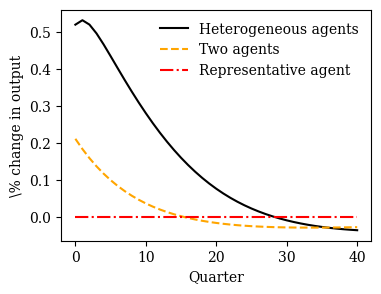

In [35]:
plt.plot(irfs_B['ha'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_B['ta'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_B['ra'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2a_replication.pdf', bbox_inches='tight')

### Alternative HANK Models and Policy Regimes

#### Figure 2(b) Replication
##### "Tax The Richest" Approach

Another fiscal alternative fixes proportional taxes at their steady-state level and allocates all additional tax adjustments to the richest agents. The authors study how the distribution of tax changes affects the deficit-financed multiplier. In the baseline, a given change in taxes or labor income is distributed proportionally across all households, so only the aggregate size matters. They then consider a progressive experiment in which households in the top income state both receive the deficit-financed tax cut and later face the tax increases required to stabilize debt.
The residual tax burden beyond the steady state is therefore borne exclusively by the top income group, allowing the model to isolate distributional responses to targeted taxation. To do this exercise, we need to rebuild the base model.

In [32]:
# Rebuild the base model
common_blocks = [production, real_ST_bonds, fiscal, capitalization, 
                 ex_post_r, nkpc, mkt_clearing]
models['ha'] = sj.combine(common_blocks + [hh_ha])


In [33]:
@sj.simple
def fiscal_richest(B, r_post_bonds, G, Y, wN, div):
    """Variant of above where any taxes beyond steady state are raised only on the richest"""
    Tax_total = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden
    T = Tax_total.ss                                # fix standard proportional taxes at steady state level
    Tax_richest = Tax_total - T                     # remaining tax burden assessed on richest
    tax_rate = T / Y
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    return T, tax_rate, wN_aftertax, div_aftertax, Tax_richest

To obtain the second part of Figure 2(b), the standard fiscal rule is replaced with the “tax-the-richest” rule defined above. The impulse response is computed by solving for the output path that clears the asset market under the same deficit-financed tax-cut shock used in the baseline case.
The resulting `irf_B_richest` shows how output responds when all marginal tax adjustments fall exclusively on the richest agents.

In [34]:
# replace regular fiscal rule with rule that taxes the richest at the margin
common_blocks_richest = common_blocks.copy()
common_blocks_richest[2] = fiscal_richest
model_ha_richest = sj.combine(common_blocks_richest + [hh_ha])

irf_B_richest = model_ha_richest.solve_impulse_linear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
                                                      inputs={'B': dB}, outputs=['Y'])['Y']

##### Taylor-Rule Monetary Policy Approach

The baseline simulations assume a neutral monetary policy, in which the real interest rate does not react to fiscal shocks, so changes in output are driven purely by the fiscal side of the model. To illustrate how monetary tightening alters these results, the authors also consider an active Taylor rule of the form $i_t = r + \phi \pi_t$ with $\phi = 1.5$, so the nominal rate increases whenever inflation rises.

In [35]:
ss_taylor = ss['ha'].copy()
ss_taylor['phi'], ss_taylor['rstar'] = 1.5, r
model_ha_taylor = sj.combine(common_blocks + [hh_ha, taylor_rule])
irf_B_taylor = model_ha_taylor.solve_impulse_linear(ss_taylor, unknowns=['Y', 'pi'], targets=['asset_mkt', 'nkpc_res'],
                                               inputs={'B': dB}, outputs=['Y'], Js=Js)['Y']

##### ALW Rule Approach

The paper also considers the ALW (2024) rule, under which the tax rate must follow an exogenously specified path. 


In the Angeletos–Lian–Wolf tax‑rate rule, the government starts from a baseline tax rate $\tau$ and implements an unfunded tax cut by lowering the rate to $\tau_t = \tau - \tau_t^X$. To first order, this implies that total tax revenue responds as $dT_t = \tau dY_t - dX_t$, where $dX_t = -Y\,d\tau_t^X$ captures the direct increase in the deficit coming from the lower tax rate. Substituting this fiscal rule into the intertemporal Keynesian cross yields

$$
dY = [I - (1-\tau)M]^{-1} M dX,
$$

so the initial deficit‑financed tax cut raises output, which in turn raises tax revenue. As long as the matrix inverse (Neumann Series) exists the extra tax revenue generated by the boom can in principle fully pay for the initial deficit, making the tax cut self‑financing.

The residual `tax_rate_res` captures the deviation of the endogenous tax rate from this target. Imposing `tax_rate_res` = 0 determines the debt path consistent with the ALW fiscal policy.


In [36]:
irf_B_ALW = models['ha'].solve_impulse_linear(ss['ha'], 
                                             unknowns=['Y', 'B'], targets=['asset_mkt', 'tax_rate_res'],
                                             inputs={'tax_rate_shock': dT_shock}, outputs=['Y'], Js=Js)['Y']


We then obtain Figure 2(b) from Auclert (2025):

<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
/var/folders/mx/8vnbs7b13n9b4gkvfrk2rgl40000gn/T/ipykernel_76778/1748106017.py:9: SyntaxWarning: invalid escape sequence '\%'


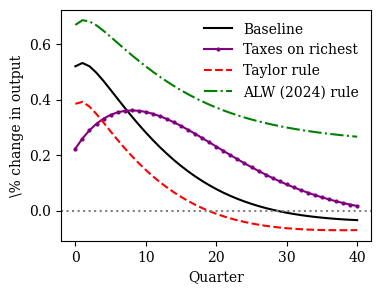

In [37]:
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_richest[:41], label='Taxes on richest', linestyle='-', color='#800080', marker='o', markersize=2)
plt.plot(irf_B_taylor[:41], label='Taylor rule', linestyle='dashed', color='red')
plt.plot(irf_B_ALW[:41], label='ALW (2024) rule', linestyle='dashdot', color='green')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2b_replication_alternative.pdf', bbox_inches='tight')